In [1]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from keras.models import Sequential, save_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras import optimizers
import keras
# from keras.applications.xception import Xception
# from keras.applications.resnet50 import ResNet50
# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg19 import VGG19
# from keras.applications.inception_v3 import InceptionV3
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet121
import cv2
import os
import seaborn as sns
# from keras.preprocessing.image import load_img, img_to_array


import warnings
warnings.filterwarnings('ignore')

def display_image(image, title=''):
    cv2.imshow(title, image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

Using TensorFlow backend.


# load data

In [2]:
#vgg can't take input of 28x28 so we shall resize all our images
pickle_folder = "pickle files"
data = pickle.load(open('data.pickle', 'rb'))
print("Data of format:")
for ch in data:
    print("data_length(" + ch + ") =", len(data[ch]))

#no. of classes
classes = len(data.keys())

Data of format:
data_length(क्ष) = 2000
data_length(ह) = 2000
data_length(व) = 2000
data_length(ट) = 2000
data_length(ड) = 2000
data_length(ग) = 2000
data_length(ध) = 2000
data_length(ण) = 2000
data_length(श) = 2000
data_length(न) = 2000
data_length(ख) = 2000
data_length(च) = 2000
data_length(त्र) = 2000
data_length(झ) = 2000
data_length(म) = 2000
data_length(छ) = 2000
data_length(ञ) = 2000
data_length(र) = 2000
data_length(द) = 2000
data_length(प) = 2000
data_length(ज) = 2000
data_length(ज्ञ) = 2000
data_length(स) = 2000
data_length(ङ) = 2000
data_length(थ) = 2000
data_length(घ) = 2000
data_length(य) = 2000
data_length(त) = 2000
data_length(फ) = 2000
data_length(ल) = 2000
data_length(क) = 2000
data_length(ठ) = 2000
data_length(ढ) = 2000
data_length(ब) = 2000
data_length(भ) = 2000
data_length(ष) = 2000


# Rearranging data in input-output format

In [3]:
file = "class_numerals_{}.pickle".format(classes)
if file in os.listdir(pickle_folder):
    class_numerals = pickle.load(open(os.path.join(pickle_folder, file), 'rb'))
    print("Unpickled")
else:
    class_numerals = {i:list(data.keys())[i] for i in range(classes)}
    pickle.dump(class_numerals, open(os.path.join(pickle_folder, file), 'wb'))
    print("Error. Incompatible. Pickled new file:", file)
def character_to_encoding(char, classes=classes):
    for i in class_numerals:
        if class_numerals[i] == char:
            return np_utils.to_categorical(i, classes)

def encoding_to_character(encoding):
    return class_numerals[encoding.argmax()]

Unpickled


In [4]:
X = []
y = []

for ch in data:
    X += data[ch]
    y += [ch] * len(data[ch])
    
#resizing input image and preprocessin
input_shape=(32, 32, 1)
X = np.array(list(map(lambda x: cv2.resize(x/255, (input_shape[0], input_shape[1])).reshape((input_shape[0], input_shape[1], 1)), X)))
y_ = np.array(list(map(lambda x: character_to_encoding(x, classes), y)))

print(X.shape, y_.shape)

(72000, 32, 32, 1) (72000, 36)


# Train-Test split

In [5]:
train_ratio = 0.8
X_train, X_test, y_train, y_test = train_test_split(X, y_, train_size=0.8, random_state=20, shuffle=True, stratify=y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((57600, 32, 32, 1), (57600, 36), (14400, 32, 32, 1), (14400, 36))

# CNN

In [6]:
import tensorflow as tf
from keras import backend as k
 
###################################
# TensorFlow wizardry
config = tf.ConfigProto()
 
# Don't pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
# config.gpu_options.per_process_gpu_memory_fraction = 0.5
 
# Create a session with the above options specified.
k.tensorflow_backend.set_session(tf.Session(config=config))


print("GPUs:", k.tensorflow_backend._get_available_gpus())

print("input shape:", input_shape)
print("classes:", classes)

def get_model_memory_usage(batch_size, model):
    import numpy as np
    from keras import backend as K

    shapes_mem_count = 0
    for l in model.layers:
        single_layer_mem = 1
        for s in l.output_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in set(model.trainable_weights)])
    non_trainable_count = np.sum([K.count_params(p) for p in set(model.non_trainable_weights)])

    total_memory = 4.0*batch_size*(shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3)
    return gbytes

GPUs: ['/job:localhost/replica:0/task:0/device:GPU:0']
input shape: (32, 32, 1)
classes: 36


creating the model below

In [12]:
%%time

batch_size = 128
num_classes = classes
epochs = 500
k_r = 0.01
b_r = 0.01
dropout = 0.1

early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=0, mode='auto')

model = Sequential()
#conv layer 
model.add(Conv2D(6, kernel_size=(5, 5),
                 activation='relu',
#                   kernel_initializer='he_normal',
#                   kernel_regularizer=keras.regularizers.l2(k_r),
#                   bias_regularizer=keras.regularizers.l2(b_r),
                 input_shape=input_shape))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(dropout))
model.add(Conv2D(12, kernel_size=(5, 5),
                 activation='relu',
#                   kernel_initializer='he_normal',
#                   kernel_regularizer=keras.regularizers.l2(k_r),
#                   bias_regularizer=keras.regularizers.l2(b_r)
                ))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(dropout))
model.add(Conv2D(120, kernel_size=(5, 5),
                 activation='relu',
#                   kernel_initializer='he_normal',
#                   kernel_regularizer=keras.regularizers.l2(k_r),
#                   bias_regularizer=keras.regularizers.l2(b_r)
                ))

# NN
model.add(Flatten())
#hidden layer 1
model.add(Dense(512, activation='relu', kernel_initializer='he_normal',
                kernel_regularizer=keras.regularizers.l2(k_r)))
model.add(Dropout(dropout))
#output laye1
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
print(model.summary())
print("\n############################")
print("## Memory usage:", get_model_memory_usage(batch_size=batch_size, model=model), "GB ##")
print("############################\n")

#adding custom weights
prev_model = keras.models.load_model(os.path.join(pickle_folder, "lenet_relu_2_conv_layer.h5"))
model.layers[0].set_weights(prev_model.layers[0].get_weights())
model.layers[3].set_weights(prev_model.layers[3].get_weights())
# model.set_weights(.get_weights())

history = model.fit(X_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_split=0.15,
        callbacks = [early_stopping_callback])
score = model.evaluate(X_test, y_test, verbose=0)
print(score)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 28, 28, 6)         156       
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 14, 14, 6)         0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 10, 10, 12)        1812      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 5, 5, 12)          0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 5, 5, 12)          0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 1, 1, 120)         36120     
__________

In [14]:
keras.models.save_model(model, os.path.join(pickle_folder, "lenet_relu_3_conv_layer.h5"))

In [54]:
prev_model.layers

In [64]:
prev_model.layers[3].get_weights()

[array([[[[-2.75508538e-02, -6.90393671e-02, -3.98493931e-02, ...,
           -5.71588203e-02, -2.61300206e-02,  9.72646326e-02],
          [-5.87070212e-02,  1.68585017e-01,  2.31030192e-02, ...,
           -4.42827567e-02, -6.42067194e-01,  1.69613063e-01],
          [-5.93029819e-02, -4.49183136e-02, -9.85606983e-02, ...,
            5.41685969e-02,  7.38759339e-03,  7.00091422e-02],
          [ 5.71903735e-02, -6.78113252e-02, -9.04231220e-02, ...,
            5.36692888e-03, -1.64651796e-02, -6.30353391e-03],
          [ 7.55127221e-02,  2.96339929e-01, -1.83536321e-01, ...,
           -2.09646106e-01,  1.04861550e-01,  8.15756395e-02],
          [ 3.67463455e-02,  1.56199172e-01,  4.29917984e-02, ...,
           -6.81556687e-02, -7.81657934e-01,  1.08693779e-01]],
 
         [[ 1.01675719e-01, -8.92165899e-02,  1.12681180e-01, ...,
            4.80272472e-02,  1.13352209e-01, -3.32784876e-02],
          [ 3.33588302e-01, -7.06137121e-01, -1.84528947e-01, ...,
            7.975597

In [66]:
model.layers[0].set_weights(prev_model.layers[0].get_weights())
model.layers[3].set_weights(prev_model.layers[3].get_weights())

In [80]:
for i in range(len(prev_model.layers)):
    print(prev_model.layers[i].get_weights())
    print(model.layers[i].get_weights())    
    print('\n\n')

[array([[[[ 6.71266690e-02,  7.70142651e+00, -7.78765392e+00,
          -1.05999015e-01, -1.02210608e+01,  4.28804827e+00]],

        [[-1.07498236e-01,  8.55134964e+00, -6.28292131e+00,
          -1.39307708e-01, -6.03516197e+00,  5.79655313e+00]],

        [[ 3.75898331e-02,  6.60877514e+00, -7.06691790e+00,
          -1.16097808e-01, -9.38235474e+00,  3.70848894e+00]],

        [[-1.31314367e-01,  5.40268612e+00, -7.15407801e+00,
          -3.34199481e-02, -1.05462761e+01,  6.43609703e-01]],

        [[ 6.27759472e-03,  5.80294895e+00, -8.79285622e+00,
           6.82735071e-02, -1.26926146e+01,  6.02687359e-01]]],


       [[[ 1.80159032e-01,  1.37124147e+01, -1.15510101e+01,
          -1.04146644e-01, -2.36054020e+01,  1.40483427e+01]],

        [[ 6.29734695e-02,  1.60369511e+01, -1.00603638e+01,
           1.41408995e-01, -2.13381271e+01,  1.91949768e+01]],

        [[ 1.08289726e-01,  1.46801624e+01, -1.06011686e+01,
          -8.66003111e-02, -2.40098057e+01,  1.94619808e+01]]

In [97]:
model.set_weights(prev_model.get_weights())
model.get_weights()

[array([[[[ 6.71266690e-02,  6.50433153e-02, -7.78765392e+00,
           -1.05999015e-01, -4.75367880e+00, -2.36383533e+00]],
 
         [[-1.07498236e-01,  6.72779918e-01, -6.28292131e+00,
           -1.39307708e-01,  2.21177131e-01, -2.52648950e+00]],
 
         [[ 3.75898331e-02, -5.05103827e+00, -7.06691790e+00,
           -1.16097808e-01, -4.69904327e+00, -8.88695526e+00]],
 
         [[-1.31314367e-01, -6.34572411e+00, -7.15407801e+00,
           -3.34199481e-02, -6.30591536e+00, -1.15962877e+01]],
 
         [[ 6.27759472e-03, -6.43097258e+00, -8.79285622e+00,
            6.82735071e-02, -9.35068130e+00, -8.02672482e+00]]],
 
 
        [[[ 1.80159032e-01,  1.27217417e+01, -1.15510101e+01,
           -1.04146644e-01, -2.42555523e+01,  1.27403526e+01]],
 
         [[ 6.29734695e-02,  1.81430874e+01, -1.00603638e+01,
            1.41408995e-01, -2.03443680e+01,  2.05735760e+01]],
 
         [[ 1.08289726e-01,  1.33029795e+01, -1.06011686e+01,
           -8.66003111e-02, -2.41381683

In [92]:
prev_model = model

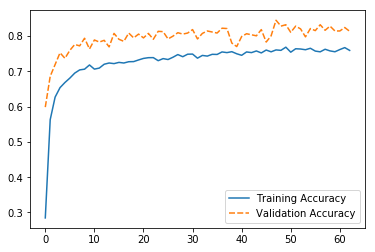

In [8]:
dicty = {
    'Training Accuracy': history.history['acc'],
    'Validation Accuracy': history.history['val_acc'],
}
sns.lineplot(data=pd.DataFrame(dicty))

In [93]:
prev_model.get_weights()

[array([[[[ 6.71266690e-02,  6.50433153e-02, -7.78765392e+00,
           -1.05999015e-01, -4.75367880e+00, -2.36383533e+00]],
 
         [[-1.07498236e-01,  6.72779918e-01, -6.28292131e+00,
           -1.39307708e-01,  2.21177131e-01, -2.52648950e+00]],
 
         [[ 3.75898331e-02, -5.05103827e+00, -7.06691790e+00,
           -1.16097808e-01, -4.69904327e+00, -8.88695526e+00]],
 
         [[-1.31314367e-01, -6.34572411e+00, -7.15407801e+00,
           -3.34199481e-02, -6.30591536e+00, -1.15962877e+01]],
 
         [[ 6.27759472e-03, -6.43097258e+00, -8.79285622e+00,
            6.82735071e-02, -9.35068130e+00, -8.02672482e+00]]],
 
 
        [[[ 1.80159032e-01,  1.27217417e+01, -1.15510101e+01,
           -1.04146644e-01, -2.42555523e+01,  1.27403526e+01]],
 
         [[ 6.29734695e-02,  1.81430874e+01, -1.00603638e+01,
            1.41408995e-01, -2.03443680e+01,  2.05735760e+01]],
 
         [[ 1.08289726e-01,  1.33029795e+01, -1.06011686e+01,
           -8.66003111e-02, -2.41381683

In [99]:
save_model(prev_model, os.path.join(pickle_folder, "lenet_relu_3_conv_layer.h5"))

In [9]:
original_model = model
# model = keras.models.load_model(os.path.join(pickle_folder, "RandomCNN_च_76.h5"))

model = original_model

predictions = model.predict(X_test)

for row in range(len(predictions)):
    predictions[row][predictions[row].argmax()] = 1
    predictions[row][predictions[row] != 1] = 0

false_array = np.all((predictions==y_test), axis=1)
num_wrong = (~false_array).sum()
print("Wrong predictions:", num_wrong, '/', y_test.shape[0], 1-num_wrong/y_test.shape[0])
wrong_walas_1 = pd.Series(list(map(encoding_to_character, predictions[~false_array]))).value_counts()
print(wrong_walas_1)


predictions = model.predict(X_train)

for row in range(len(predictions)):
    predictions[row][predictions[row].argmax()] = 1
    predictions[row][predictions[row] != 1] = 0

false_array = np.all((predictions==y_train), axis=1)
num_wrong = (~false_array).sum()
print("Wrong predictions:", num_wrong, '/', y_train.shape[0], 1-num_wrong/y_train.shape[0])
wrong_walas_2 = pd.Series(list(map(encoding_to_character, predictions[~false_array]))).value_counts()
print(wrong_walas_2)

Wrong predictions: 302 / 1697 0.8220388921626399
थ      32
व      23
ञ      21
भ      18
ट      14
र      13
ए      13
त      12
य      11
द      11
ड       9
ष       8
उ       8
ज       8
प       8
ह       7
ज्ञ     7
त्र     6
ल       6
च       6
स       5
ग       5
ब       5
न       5
क       4
अ       4
फ       4
झ       4
ऊ       3
ङ       3
ध       3
ठ       3
घ       2
ख       2
इ       2
ढ       2
म       2
छ       1
श       1
ण       1
dtype: int64
Wrong predictions: 748 / 6788 0.8898055391868003
व      65
थ      60
ञ      43
भ      41
ट      36
द      33
ष      30
ज      29
ड      28
त      27
य      24
र      23
घ      20
ए      20
प      18
ढ      18
उ      17
स      16
ज्ञ    16
ल      15
ग      13
त्र    13
ह      12
इ      12
ण      11
झ      11
क      11
श      11
न      10
फ      10
च      10
म       8
ठ       8
अ       7
ब       7
ङ       4
ध       3
छ       3
ख       2
क्ष     2
ऊ       1
dtype: int64


In [27]:
a = keras.models.load_model(os.path.join(pickle_folder, "lenet_relu_1_conv_layer.h5"))

count = 10
a = ~false_array
for i in range(len(a)):
    if a[i]:
        count -= 1
        print(count, encoding_to_character(predictions[i]), encoding_to_character(y_test[i]))
        display_image(X_test[i])
        if count <= 0:
            break

In [11]:
file_name = "RandomCNN_"+str(wrong_walas_1.argmax())+'_'+str(wrong_walas_1[0])
if file_name + '.h5' not in os.listdir(pickle_folder):
    save_model(model, os.path.join(pickle_folder, file_name + '.h5'))
    f = open(os.path.join(pickle_folder, file_name + '.txt'), 'w')
    f.write(str(wrong_walas_1))
    f.write("\n\n")
    f.write(str(wrong_walas_2))
    f.close()
print(file_name)

RandomCNN_थ_32
